In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import seaborn as sns
import LCDMSphere
import Energy_loss_class
import Source_class

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
k = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G

In [2]:
# calculate overdensity evolution
C = LCDMSphere.XCosmo(0.6774, 0.319)
C.overdensity_evol(50., -10., 200)
z_list = C.z_grid # redshift grid
delta_b = C.Delta_grid # overdensity of baryon
Delta_list = np.array([1 + x for x in delta_b]) # relative overdensity of baryon - grid
ln_Delta = [np.log(x) for x in Delta_list]

dDdz = np.zeros((len(z_list) - 1, )) # d ln(Delta)/dz
for i in range(len(z_list) - 1):
    dDdz[i] = (ln_Delta[i+1] - ln_Delta[i]) / (z_list[i+1] - z_list[i])

z = (z_list[:-1] + z_list[1:]) / 2 # midpoint of z grid, correspond to d ln(Delta)/dz
    
Delta = (Delta_list[:-1] + Delta_list[1:]) / 2 # midpoint of overdensity grid, correspond to d ln(Delta)/dz
    
H = np.zeros((len(z), ))
for i in range(len(z)):
    H[i] = C.H(z[i])
    
theta = np.zeros((len(z), ))
for i in range(len(theta)):
    theta[i] = 3 * H[i] - dDdz[i]

In [3]:
# coefficient of dN(E, t)/dE
def A2(E, z, Delta_i, theta_i):
    loss = Energy_loss_class.Loss(z, E, Delta_i)
    co1 = theta_i / 3 * E * (E + 2 * E_e) / (E + E_e)
    co2 = loss.E_loss()
    return co1 - co2

In [4]:
# coefficient due to secondary electron
def A3(E, E_p, z):
    omega_b = omega_b_0 * (1 + z)**3
    n_H = 0.76 * omega_b * rho_crit / m_p
    n_etot = n_H * (1 + 2 * f_He)
    beta_p = np.sqrt(E_p * (E_p + 2 * E_e)) / (E_p + E_e)
    co1 = 2 * np.pi * r0 * r0 * E_e * (E_e + E_p)**2 / E_p / (2 * E_e + E_p) / E / E
    co2 = 1 + E * E / (E_p - E)**2 + E * E / (E_e + E_p)**2 - E_e * (E_e + 2 * E_p) * E/ (E_e + E_p)**2 / (E_p - E)
    return n_etot * c * beta_p * co1 * co2

In [5]:
E_min = 1e-8 # temp, in erg
E_max = 1e-3 # temp, in erg

mstep = len(z) # E length, the matrix should be a square matrix because dN/dz and N have the same length (# bins)

E = np.logspace(np.log10(E_min), np.log10(E_max), mstep + 1)

E_mid = (E[:-1] + E[1:]) / 2
E_p = np.zeros((mstep+1, 1)) # E_{i+1/2} = sqrt(E[i] * E[i+1])
E_m = np.zeros((mstep+1, 1)) # E_{i-1/2} = sqrt(E[i-1] * E[i])

for i in range(mstep):
    E_p[i] = np.sqrt(E[i] * E[i+1]) # length len(E) -1

dlnE = np.log(E[-1] / E[-2])
E_p[-1] = E_p[-2] * np.exp(dlnE)

for i in range(1, mstep+1):
    E_m[i] = np.sqrt(E[i] * E[i-1])
    
dlnE = np.log(E[1] / E[0])
E_m[0] = E_m[1] / np.exp(dlnE)

In [6]:
S = np.loadtxt("source_term.txt") # in 'same columns, same redshift; same row, same energy' format 
S = np.delete(S, 0, axis=1)
S_trans = np.transpose(S) # in 'same columns, same energy; same row, same redshift' format 

In [7]:
def get_M(z, Delta, theta): # parameters that only depend on redshift
    M = np.zeros((mstep, mstep))

    for i in range(mstep):
        for j in range(mstep):
            if j == i or j == i-1 or j == i+1:
                A1_ij = -theta
        
                A2_ij = A2(E[j], z, Delta, theta)
                A2_ij_p = A2(E_p[j], z, Delta, theta)
                A2_ij_m = A2(E_m[j], z, Delta, theta)
        
                dE = E[j+1] - E[j]
                dE_p = E_p[j+1] - E_p[j]
                dE_m = E_m[j+1] - E_m[j]
        
                if j == i:
                    M[i][j] += A1_ij + A2_ij_p * (1/2/dE_p - 1/dE) - A2_ij_m * (1/2/dE_m - 1/dE)
                if j == i-1:
                    M[i][j] -= A2_ij_m / 2 / dE_m
                if j == i+1:
                    M[i][j] += A2_ij_p / 2 / dE_p
                
            if E[j] >= 2 * E[i]:
                M[i][j] += A3(E[i], E[j], z)
                
    return M

In [8]:
def back_Euler(S): # solve dN/dz = MN + S using backward Euler method, M is square matrix, S is column vector
    N = np.zeros((mstep, mstep))
    I = np.identity(mstep)
    
    for i in range(mstep-1):
        dz = z[i+1] - z[i]
        
        M = get_M(z[i+1], Delta[i+1], theta[i+1])
        dzM = np.dot(dz, M)
        
        I_minus_dzM = [[I[i][j] - dzM[i][j]  for j in range(len(I[0]))] for i in range(len(I))]
        I_m_inv = np.linalg.inv(I_minus_dzM)
        
        dzS = np.dot(dz, S[i+1])
        
        yi_plus_dzS = [N[i][j] + dzS[j] for j in range(len(N[i]))]
        
        N[i+1] = np.dot(I_m_inv, yi_plus_dzS)
        
    return N

In [9]:
N = back_Euler(S_trans)

In [12]:
N_dataframe = pd.DataFrame(data=N, index=z, columns=E_mid)

<AxesSubplot:>

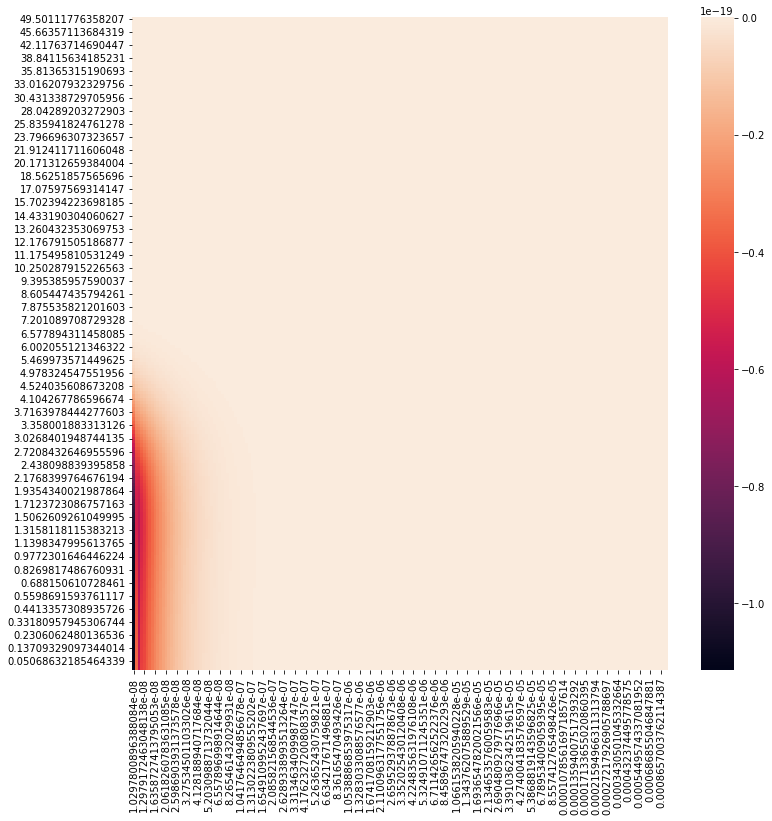

In [14]:
plt.figure(figsize = (12,12))
sns.heatmap(N_dataframe)

In [15]:
N_log = np.zeros((mstep, mstep))
for i in range(mstep):
    for j in range(mstep):
        if N[i][j] > 0:
            N_log[i][j] = np.log10(N[i][j])
        elif N[i][j] < 0:
            N_log[i][j] = -np.log10(-N[i][j])
        elif N[i][j] == 0:
            N_log[i][j] = 0

In [16]:
N_log_dataframe = pd.DataFrame(data=N_log, index=z, columns=E_mid)

<AxesSubplot:>

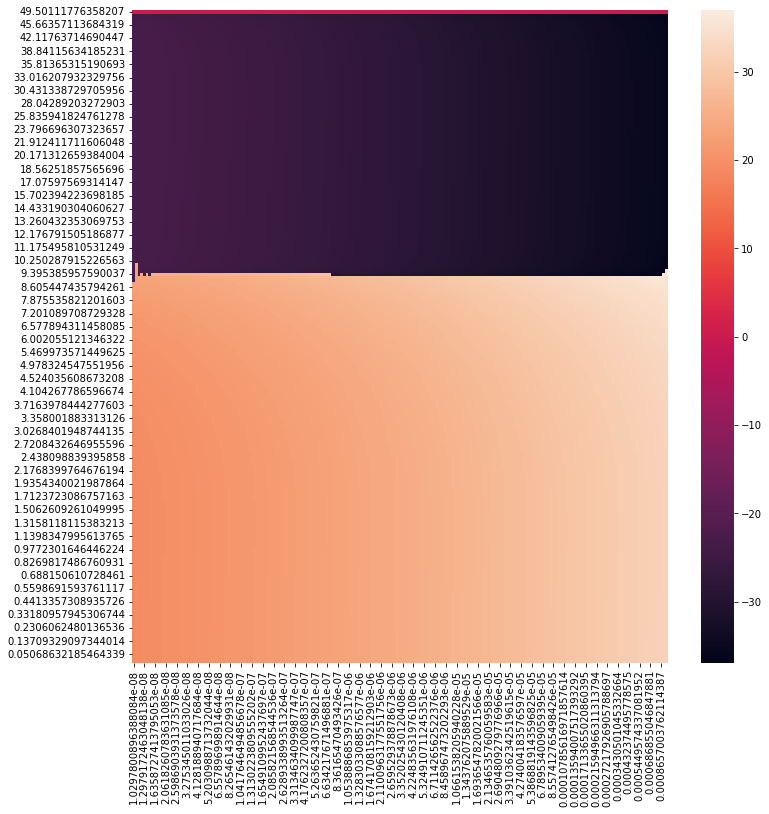

In [17]:
plt.figure(figsize = (12,12))
sns.heatmap(N_log_dataframe)

In [23]:
# P = -integrate(E(dN/dt V + N dV/dt)dE dt/dV)
# V = 1/V dV/dt = 3H - dlnDelta/dt -> V = 1/(3H-dlnDelta/dt) dV/dt
# P = -integrate(E(dN/dt 1/(3H-dlnDelta/dt) + N)dE)

# N[i][j]: N[i] donte to same z and different E

for i in range(mstep-1): # z
    P = 0 # in cgs unit, 1 dyne/cm^2 = 0.1 Pa
    
    for j in range(mstep): # E
        dNdz = (N[i+1][j] - N[i][j]) / (z[i+1] - z[i])
        P += -E_mid[j] * (dNdz / (3 * H[i] - dDdz[i]) + N[i][j]) * (E[j+1] - E[j])
        
    print(f'P({i}) = {P}')

P(0) = -8.52583420524425e-37
P(1) = -7.511513223382363e-37
P(2) = -6.612937586501381e-37
P(3) = -5.81706177196933e-37
P(4) = -5.112296953389428e-37
P(5) = -4.4883498447393725e-37
P(6) = -3.936079188744578e-37
P(7) = -3.4473679823530563e-37
P(8) = -3.0150097348356983e-37
P(9) = -2.632607235680995e-37
P(10) = -2.294482472134689e-37
P(11) = -1.995596481966984e-37
P(12) = -1.7314780574196675e-37
P(13) = -1.4981603329732881e-37
P(14) = -1.2921243939130835e-37
P(15) = -1.110249135966263e-37
P(16) = -9.497666896445022e-38
P(17) = -8.082227974205772e-38
P(18) = -6.834415983907659e-38
P(19) = -5.734943344717123e-38
P(20) = -4.766715452039904e-38
P(21) = -3.914583655447656e-38
P(22) = -3.1651258323883273e-38
P(23) = -2.506451500066669e-38
P(24) = -1.9280287435224213e-38
P(25) = -1.4205305371904547e-38
P(26) = -9.756983039328377e-39
P(27) = -5.862207931835054e-39
P(28) = -2.456265715798304e-39
P(29) = 5.18113919714652e-40
P(30) = 3.111603968796802e-39
P(31) = 5.3690313768011426e-39
P(32) = 7.3300

In [22]:
with open('N.txt', 'a') as f:
    for i in range(mstep):
        for j in range(mstep):
            f.write(str(N[i][j])+' ')
        f.write('\n')
f.close()